# Sparse matrices and iterative methods

## Sparse format

Large matrices whose entries are mostly zeros are typically called *sparse*. They can be stored more efficiently than "dense" or full matrices, but must explicitly be constructed as a sparse type. 

In [1]:
using LinearAlgebra, SparseArrays
A = sprandn(10000,10000,0.0004);
varinfo(Main,r"A")

| name |        size | summary                                    |
|:---- | -----------:|:------------------------------------------ |
| A    | 707.883 KiB | 10000×10000 SparseMatrixCSC{Float64,Int64} |


The equivalent full (or "dense") matrix requires almost 800 MB of storage. 

In [2]:
Afull = Matrix(A);
varinfo(Main,r"Afull")

| name  |        size | summary                      |
|:----- | -----------:|:---------------------------- |
| Afull | 762.939 MiB | 10000×10000 Array{Float64,2} |


Two common ways to inspect a sparse matrix are `nnz`, the number of nonzeros, and `spy`, which shows the locations of the nonzeros.

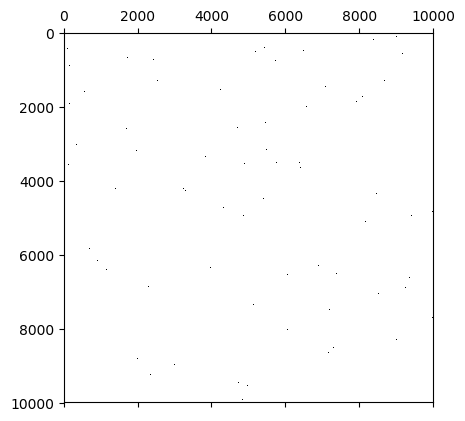

40294

In [3]:
using PyPlot
spy(Afull)
nnz(A)

You can use `findnz` to get all the nonzero elements and their locations.

In [4]:
i,j,s = findnz(A)

([3022, 3751, 4544, 4821, 3846, 3855, 8595, 112, 1890, 3078  …  3334, 5195, 5595, 6099, 2729, 5233, 3818, 6991, 7090, 9040], [1, 1, 1, 1, 2, 2, 2, 3, 3, 3  …  9998, 9998, 9998, 9998, 9999, 9999, 10000, 10000, 10000, 10000], [1.10703, -1.59044, -0.578879, -1.94638, -0.554971, -1.38665, 0.590012, 0.646307, 0.0151332, -0.0298211  …  -0.233326, -0.196126, -0.216334, 0.361577, 1.35334, 1.68348, 0.832822, -0.944676, 0.792592, -0.754181])

In [5]:
(s[1],A[i[1],j[1]])

(1.1070333306623361, 1.1070333306623361)

## Making sparse matrices

If the matrix is not too big, you can construct it as usual and then use `sparse` to convert it. This is rarely the best option for real work, though. 

You can also use the `sparse` function to construct a sparse matrix, essentially as the inverse operation of `findnz` above.

In [6]:
AA = sparse(i,j,s,10000,10000)

10000×10000 SparseMatrixCSC{Float64,Int64} with 40294 stored entries:
  [3022 ,     1]  =  1.10703
  [3751 ,     1]  =  -1.59044
  [4544 ,     1]  =  -0.578879
  [4821 ,     1]  =  -1.94638
  [3846 ,     2]  =  -0.554971
  [3855 ,     2]  =  -1.38665
  [8595 ,     2]  =  0.590012
  [112  ,     3]  =  0.646307
  [1890 ,     3]  =  0.0151332
  [3078 ,     3]  =  -0.0298211
  [876  ,     4]  =  0.997834
  [4617 ,     4]  =  -0.377948
  ⋮
  [9107 ,  9997]  =  1.56857
  [1630 ,  9998]  =  -0.24159
  [3334 ,  9998]  =  -0.233326
  [5195 ,  9998]  =  -0.196126
  [5595 ,  9998]  =  -0.216334
  [6099 ,  9998]  =  0.361577
  [2729 ,  9999]  =  1.35334
  [5233 ,  9999]  =  1.68348
  [3818 , 10000]  =  0.832822
  [6991 , 10000]  =  -0.944676
  [7090 , 10000]  =  0.792592
  [9040 , 10000]  =  -0.754181

Sometimes it's handy to construct a sparse matrix by its values along diagonals, using `spdiagm`.

In [7]:
B = spdiagm( 0=>1:6, 2=>1:4, -1=>10:10:50 )

6×6 SparseMatrixCSC{Int64,Int64} with 15 stored entries:
  [1, 1]  =  1
  [2, 1]  =  10
  [2, 2]  =  2
  [3, 2]  =  20
  [1, 3]  =  1
  [3, 3]  =  3
  [4, 3]  =  30
  [2, 4]  =  2
  [4, 4]  =  4
  [5, 4]  =  40
  [3, 5]  =  3
  [5, 5]  =  5
  [6, 5]  =  50
  [4, 6]  =  4
  [6, 6]  =  6

In [8]:
Matrix(B)

6×6 Array{Int64,2}:
  1   0   1   0   0  0
 10   2   0   2   0  0
  0  20   3   0   3  0
  0   0  30   4   0  4
  0   0   0  40   5  0
  0   0   0   0  50  6

## Sparse operations

Sparse matrices are not just more memory-efficient. They are able to ignore structural zeros when taking sums and products.

In [9]:
v = rand(10000);

@time for k = 1:100 
    A*v; 
end


  0.051341 seconds (89.11 k allocations: 12.142 MiB, 14.09% gc time)


In [10]:
@time for k = 1:100
    Afull*v; 
end

  4.346933 seconds (263.76 k allocations: 20.438 MiB, 0.13% gc time)


One thing to watch out for, though: the way a sparse matrix is stored can make column operations a *lot* faster than row operations, so plan accordingly. 

In [11]:
B = copy(A);
@time B[1000,:] = sum(B,dims=1); 
B = copy(A);
@time B[:,1000] = sum(B,dims=2); 

  0.528145 seconds (2.18 M allocations: 108.339 MiB, 6.97% gc time)
  0.089441 seconds (287.83 k allocations: 15.701 MiB)


## Sparse backslash

There are algorithms that attempt to exploit sparsity when solving linear systems of equations. They will be called automatically when backslash is used on a sparse matrix. The time required varies wildly, but these methods can be surprisingly effective, especially for well-known common problems such as the 5-point Laplacian approximation. 

In [12]:
n = 500; @show m = (n-1)^2
J = spdiagm(0=>ones(n-1)); D = spdiagm(0=>fill(-2.,n-1),1=>ones(n-2),-1=>ones(n-2))/n^2
L = kron(J,D) + kron(D,J);
b = ones(m);
@time x = L\b; 

m = (n - 1) ^ 2 = 249001
  3.656261 seconds (5.41 M allocations: 686.400 MiB, 5.31% gc time)


As you can see, a 250,000 by 250,000 matrix might not be considered 'large' in every sense!

## Matrix fill-in

Not all is easy in sparse-land, though. The problem is that most operations on sparse matrices leave them less sparse, a phenomenon called *fill-in*.

Take matrix powers, for example.

In [15]:
A = sprandn(10000,10000,.0005)
@show nnz(A);
@show nnz(A*A);
@show nnz(A*A*A);

nnz(A) = 50420
nnz(A * A) = 253826
nnz(A * A * A) = 1271047


Algorithmically speaking, when we write $A^3x$, we think of it as $A(A(Ax))$, which is much faster in the general sparse case. 

Fill-in is especially damaging when attempting LU factorization. Bandedness can be preserved if pivoting is not used, but that invites instability.

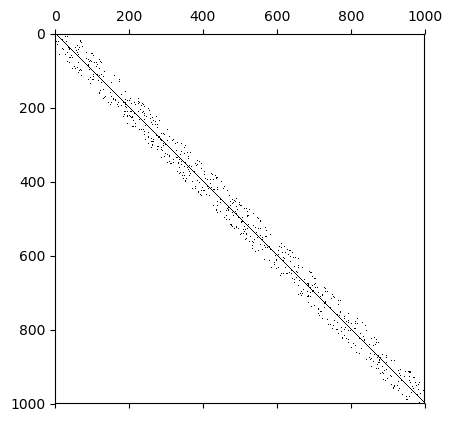

PyObject <matplotlib.image.AxesImage object at 0x171f032b0>

In [26]:
A = triu(tril(sprandn(1000,1000,0.05),50),-50) + 0.05I;
using PyPlot
spy(Matrix(A))

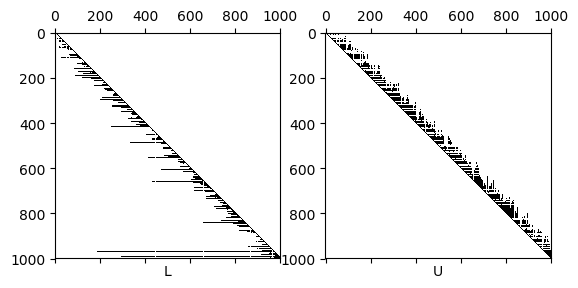

(PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x171f316a0>, PyObject <matplotlib.image.AxesImage object at 0x1603d1518>, PyObject Text(0.5,24,'U'))

In [27]:
L,U = lu(Matrix(A))
subplot(121), spy(L), xlabel("L")
subplot(122), spy(U), xlabel("U")

There are clever heuristics for minimizing the fill-in, but they are far from foolproof. 